In [105]:
# Utilities
import kaggle
import pandas as pd
import numpy as np
from sklearn import linear_model
import pandas as pd
import numpy as np
import warnings
from scipy.stats import randint, uniform
import glob,os

warnings.filterwarnings('ignore')

#Visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from zipfile import ZipFile

#Modelling

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.callbacks import TensorBoard
from keras.layers import Dense, BatchNormalization
from keras.layers import Dropout
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import sklearn.feature_selection as feature_selection
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import sklearn.linear_model as linear
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [106]:
api = KaggleApi()
api.authenticate()
api.competition_download_files('titanic')
zf = ZipFile('titanic.zip')
zf.extractall('data/') #save files in selected folder
zf.close()

In [107]:
path = os.getcwd()+'/data'
filenames = [filename for filename in glob.glob(os.path.join(path, '*.csv'))]
train = pd.read_csv(filenames[-1],index_col=0)
test = pd.read_csv(filenames[1],index_col=0)
data = pd.concat([train,test])
data.reset_index(inplace=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Data Exploration

891 examples, 11 features, the target var (survived)

- SibSp: number of siblings / spouses aboard
- Parch: number of parents / children aboard
- Cabin: cabin number
- Embarked: port of embarkation
- Pclass: ticket class
- Fare: fare price in numerical value

In [108]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


### Number of Null value
We can find out there are some missing values in 'Cabin' and 'Age', and also a little in 'Embarked'.

In [109]:
# Check NaN values in training
print(train.isna().sum())
print('---------------------')
print(data.isna().sum())

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64
---------------------
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


Text(0.5, 0, 'Number of Missing values')

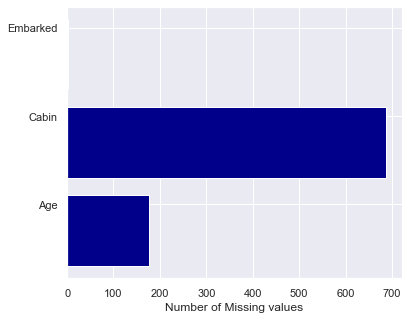

In [110]:
#bar graph showing number of null values in embarked, cabin and age                                                                                                                                                                                                                                                                      %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)

null_columns=train.columns[train.isnull().any()]
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(train[col].isnull().sum())
ind = np.arange(len(labels))
ind
width=0.6
fig, ax = plt.subplots(figsize=(6,5))
rects = ax.barh(ind, np.array(values), color='darkblue')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Number of Missing values")

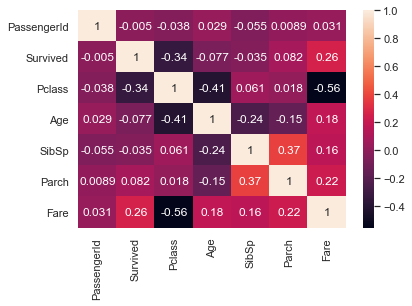

In [111]:
#seaborn get feature correlation
ax = sns.heatmap(data.corr(),annot=True)

### Family_size

In [112]:
#family size Feature Engineering
data['family_size'] = data['SibSp'] + data['Parch']+1

### Passenger names and titles

In [113]:
print(data.Name.head(20))

#extract title
data['Title'] = data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
data['Title'].unique()

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [114]:
#pandas crosstab to check the relationship between titles and passenger sex
pd.crosstab(data['Title'], data['Sex'])
data['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)  #unmarried
data['Title'].replace(to_replace='Mme', value='Mrs', inplace=True)            #married
data['Title'].replace(to_replace=['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir',
                                         'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                                             value='Other', inplace=True)     #other undecided titles
pd.crosstab(data['Title'], data['Sex'])


Sex,female,male
Title,,
Master,0,61
Miss,264,0
Mr,0,757
Mrs,198,0
Other,4,25


### Sex

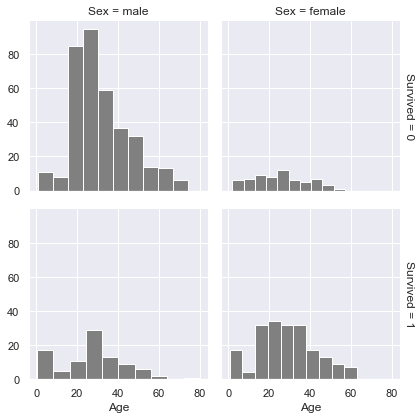

In [115]:
g = sns.FacetGrid(train, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist, "Age",color="grey");

In [116]:
#Map sex into a more explicit name and into binary value
sex_map = {'male':1, 'female':0}
data['Sex'] = data['Sex'].map(sex_map)
data['IsMale'] = data['Sex']
data = data.drop(['Sex'],axis=1)

### Group information idenftied by groupidentifier (lastname, Pclass, ticket info,fare,embarkation)

In [117]:
# Engineer group information
lastname = data['Name'].apply(lambda x:x[:x.find(',')])
ticket = data['Ticket'].apply(lambda x:x[:-1])
data['groupidentifier'] = (lastname.astype(str) + '-' + data['Pclass'].astype(str) + '-' + ticket.astype(str) + '-' + data['Fare'].astype(str) + '-' +  data['Embarked'].astype(str)) 
data['TicketId'] = (data['Pclass'].astype(str) + '-' + ticket.astype(str) + '-' + data['Fare'].astype(str)+ '-' +  data['Embarked'].astype(str)) 

data['Title1'] = 'man'
data.Title1[data['IsMale'] == 0] = 'woman'
data.Title1[data['Title'].str.contains('Master')] = 'children'
data.groupidentifier[data['Title1'] == 'man'] = 'Nogroup'

data['GroupSize'] = data.groupby('groupidentifier')['groupidentifier'].transform('count')
data.loc[data['GroupSize'] <= 1, 'groupidentifier'] = 'Nogroup'

#adding nannies and relatives, 9 these passengers are added to the group
print(len(data[data['groupidentifier']=='Nogroup']))

for inx in data.loc[(data['Title1'] != 'man') & (data['groupidentifier']=='Nogroup'), 'PassengerId']:
    data.loc[data['PassengerId']==inx,'groupidentifier'] = (data.loc[(data['TicketId']==data.loc[(data['PassengerId']==inx),'TicketId'].values[0]),'groupidentifier']).values[0]

1090


### To further break down group information, we used the Wcg (Woman-Child-Group) advised by peer bloggers

In [118]:
# Engineer Woman-Child-Group
data['InWcg'] = 0
data.loc[data['groupidentifier']!='Nogroup','InWcg'] = 1

data['WcgAllSurvived'] = data.loc[data['InWcg'] == 1].groupby('groupidentifier')['Survived'].transform(np.nanmean)

# `np.nanmean` returns NaN for groups without survival information (test set only groups)
# Replace the NaN with 0
data.loc[data['WcgAllSurvived'].isna(), 'WcgAllSurvived'] = 0
data['WcgAllSurvived'] = data['WcgAllSurvived'].astype(int)

# Add to the train and test datasets
data['WcgAllDied'] = (1 - data.loc[data['InWcg'] == 1].groupby('groupidentifier')['Survived'].transform(np.nanmean))

# Replace the NaN with 0
data.loc[data['WcgAllDied'].isna(), 'WcgAllDied'] = 0
data['WcgAllDied'] = data['WcgAllDied'].astype(int)

data = data.drop(columns=['Title','Title1','GroupSize','groupidentifier','TicketId'],axis=1)
data

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,IsMale,InWcg,WcgAllSurvived,WcgAllDied
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,2,1,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,2,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,2,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,1,1,0,0,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,1,0,0,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,0,0,0
1307,1308,NaN,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,1,1,0,0,0


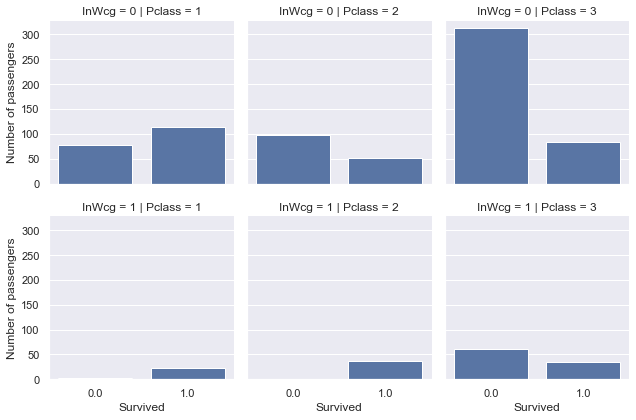

In [119]:
# plot the relationship between InWcg, Pclass and Survival info
ff = pd.DataFrame(data.groupby(['InWcg','Pclass'])['Survived'].value_counts())
ff = ff.reset_index(level=[0,1])
ff.columns = ['InWcg','Pclass','Number of passengers']
ff = ff.reset_index()
new_row = {'Survived':0, 'InWcg':1, 'Pclass':2, 'Number of passengers':0}
ff = ff.append(new_row,ignore_index=True)

sns.color_palette("hls", 8)
g = sns.FacetGrid(data=ff, col='Pclass',row='InWcg')
g.map(sns.barplot, "Survived", "Number of passengers")

### Age prediction and binning using KMeans, we also tried feature matching, fillna with median and qcut (cuts)

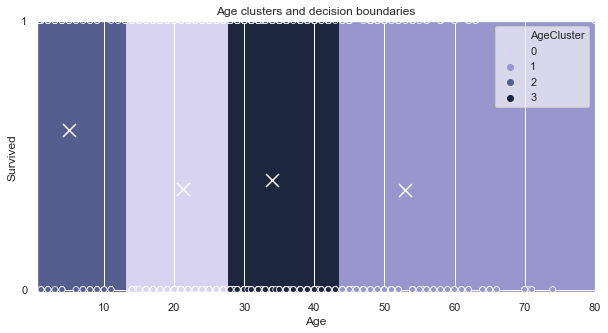

Age bands: [ 0.   13.16 27.67 43.52   inf]


In [120]:
num_clusters = 4
X = train[[ 'Age', 'Survived']].dropna()
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)
X['AgeCluster'] = kmeans.labels_

# Plot the decision boundary
plt.figure(figsize=(10,5))
h = 0.01
x_min, x_max = X['Age'].min() - h, X['Age'].max() + h
y_min, y_max = X['Survived'].min() - h, X['Survived'].max() + h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the age cluster for each point in a mesh
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
cmap = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=cmap, aspect='auto')

# Plot the ages
sns.scatterplot(x='Age', y='Survived', hue='AgeCluster', data=X, palette=cmap)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w')
plt.yticks([0, 1])
plt.title("Age clusters and decision boundaries")
plt.show()

age_bands = []
for k in range(num_clusters):
    age_bands.append(xx[Z==k].min())

# sort the intervals
age_bands.sort()
# Set the lower bound of the first interval to 0
age_bands[0] = 0
# Set the higher bound of the last interval to infinite just in case there are older older passengers in the test set
age_bands.append(np.inf)

# Convert list to numpy array
print("Age bands: {}".format(np.array(age_bands)))

data['AgeBand'] = pd.cut(data['Age'], age_bands)

In [121]:
#fill in missing ages
fill_age_df = data[['Name', 'AgeBand', 'Pclass', 'SibSp', 'Parch', 'IsMale']].copy()
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 2:x.find('.')])
fill_age_df['Title'].replace(to_replace=['Mlle', 'Ms'], value='Miss', inplace=True)
fill_age_df['Title'].replace(to_replace='Mme', value='Mrs', inplace=True)
fill_age_df['Title'].replace(to_replace=['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir',
                                         'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                             value='Rare', inplace=True)
title_dummies = pd.get_dummies(fill_age_df['Title'], drop_first=True)
fill_age_df = pd.concat([fill_age_df, title_dummies], axis=1)

fill_age_df['AgeBand'] = fill_age_df['AgeBand'].astype('category').cat.codes

fill_age_df.drop(columns=['Name','Title'], inplace=True)


X_train = fill_age_df.loc[fill_age_df['AgeBand'] != -1].drop(columns='AgeBand')
y_train = fill_age_df['AgeBand'].loc[fill_age_df['AgeBand'] != -1]

X = fill_age_df.loc[fill_age_df['AgeBand'] == -1].drop(columns='AgeBand')

tree = DecisionTreeClassifier(random_state=0)
tree_scores = cross_val_score(tree, X_train, y_train, cv=10)
print("Tree Classifier cross-validation scores: {:.3f}".format(tree_scores.mean()))

tree.fit(X_train, y_train)

Y = tree.predict(X)
fill_age_df.loc[fill_age_df['AgeBand'] == -1, 'AgeBand'] = Y

data['AgeBand'] = fill_age_df['AgeBand']



Tree Classifier cross-validation scores: 0.536


### plot age with regard to survival

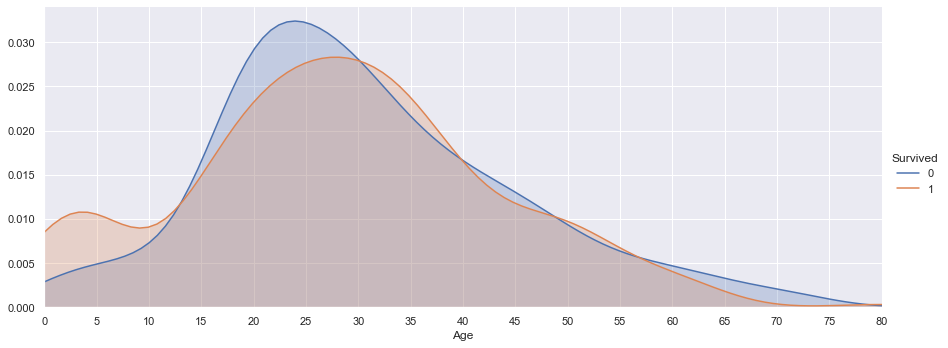

In [122]:
# try another age band
with sns.axes_style("darkgrid"):
    g = sns.FacetGrid(train, hue='Survived', height=5, aspect=2.5)
    g.map(sns.kdeplot, 'Age', shade=True)
    g.add_legend()
    g.set(xticks=np.arange(0, train['Age'].max() + 1, 5), xlim=(0, data['Age'].max()))


In [123]:
# FE IsAlone
data['IsAlone'] = 0 
data['IsAlone'].loc[data['family_size'] <= 1] = 1

In [124]:
# Split all fares into 4 bins
let = LabelEncoder()
enc = OneHotEncoder()
data['Fare'].fillna(value=data['Fare'].median(),inplace=True)
data['FareBin'] = pd.qcut(data['Fare'], 4)
data['FareBin_Code'] = let.fit_transform(data['FareBin'])

In [125]:
data

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_size,IsMale,InWcg,WcgAllSurvived,WcgAllDied,AgeBand,IsAlone,FareBin,FareBin_Code
0,1,0.0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,2,1,0,0,0,1,0,"(-0.001, 7.896]",0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,2,0,0,0,0,2,0,"(31.275, 512.329]",3
2,3,1.0,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0,0,0,1,1,"(7.896, 14.454]",1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,2,0,0,0,0,2,0,"(31.275, 512.329]",3
4,5,0.0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1,1,0,0,0,2,1,"(7.896, 14.454]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,S,1,1,0,0,0,1,1,"(7.896, 14.454]",1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,C,1,0,0,0,0,2,1,"(31.275, 512.329]",3
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,1,0,0,0,2,1,"(-0.001, 7.896]",0
1307,1308,NaN,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,S,1,1,0,0,0,1,1,"(7.896, 14.454]",1


### Cabin FE

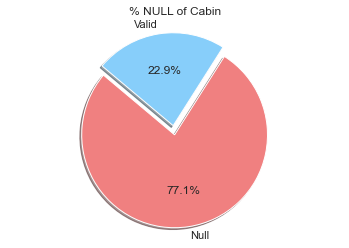

In [126]:
labels = 'Null', 'Valid'

sizes = [train['Cabin'].isna().sum(), train['Cabin'].notna().sum()]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0) 

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("% NULL of Cabin")
plt.axis('equal')
plt.show()

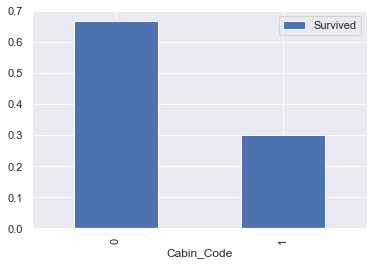

In [127]:
# FE cabin information
data['Cabin_Code'] = data['Cabin'].str[0]
data['Cabin_Code'].replace('T','A',inplace=True)
data['Cabin_Code'].fillna(value='N',inplace=True)
data['Cabin_Code'] = data['Cabin_Code'].replace(['A', 'B','C',"D",'E','T'], 0)
data['Cabin_Code'] = data['Cabin_Code'].replace(['F','G'], 0)
data['Cabin_Code'] = data['Cabin_Code'].replace(['N'], 1)

data[['Cabin_Code','Survived']].groupby('Cabin_Code').mean().plot(kind='bar')


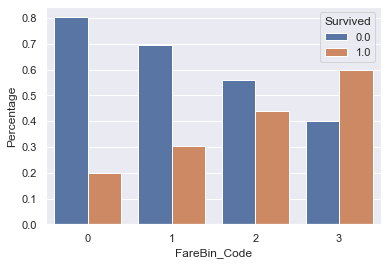

In [128]:
# train test split (data leakage notice)
train = data.iloc[:len(train),]
test_ = data.iloc[len(train):,]

w = train.groupby('FareBin_Code')['Survived'].value_counts(normalize=True)
e = w.rename('Percentage').reset_index()
p = sns.barplot(x="FareBin_Code", y="Percentage", hue="Survived", data=e)

### Prepare for modelling

In [129]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

y = train.Survived
X = train.drop(columns=['PassengerId','SibSp','Parch','Fare','Embarked','family_size',"Survived","Name","Ticket","Age",'Cabin','FareBin'],axis=1)
X_test=test_.drop(columns=['PassengerId','SibSp','Parch','Fare','Embarked','family_size',"Survived","Name","Ticket","Age",'Cabin','FareBin'],axis=1)

X

,Pclass,IsMale,InWcg,WcgAllSurvived,WcgAllDied,AgeBand,IsAlone,FareBin_Code,Cabin_Code
0,3,1,0,0,0,1,0,0,1
1,1,0,0,0,0,2,0,3,0
2,3,0,0,0,0,1,1,1,1
3,1,0,0,0,0,2,0,3,0
4,3,1,0,0,0,2,1,1,1
...,...,...,...,...,...,...,...,...,...
886,2,1,0,0,0,1,1,1,1
887,1,0,0,0,0,1,1,2,0
888,3,0,1,0,1,0,0,2,1
889,1,1,0,0,0,1,1,2,0


In [130]:
# A function to show the results with parameter search
def report(results, n_top=3, limit=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        if limit is not None:
            candidates = candidates[:limit]
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print()



### Bagging forest classifier with feature importance

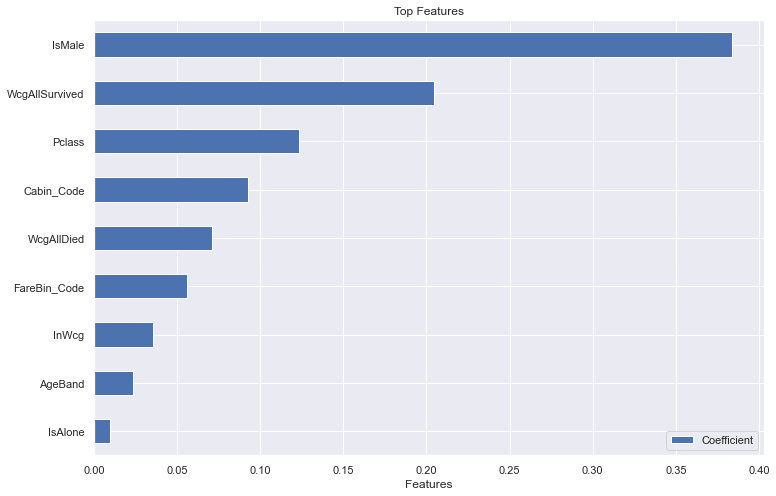

In [131]:
model_bc = BaggingClassifier(RandomForestClassifier(criterion='gini',n_estimators=200,max_depth=3))
model_bc.fit(X,y)

feature_importances = np.mean([
    tree.feature_importances_ for tree in model_bc.estimators_
], axis=0)
coeff_df = pd.DataFrame(feature_importances,np.array(X.columns),columns=['Coefficient'])

fig, ax = plt.subplots(1,1,figsize=(12,8))
coeff_df.sort_values(by='Coefficient',ascending=True).plot(kind='barh',ax=ax)
plt.xlabel('Features')
plt.title('Top Features');


In [132]:
model_bc = Pipeline(steps=[('scaler',StandardScaler()), 
                           ('brf',BaggingClassifier(RandomForestClassifier(criterion='gini',n_estimators=200,max_depth=3)))
                          ])

param_grid = {
 "brf__base_estimator__max_depth": [3, 4, 5],
 "brf__base_estimator__bootstrap": [True, False],    
 "brf__base_estimator__n_estimators": [100, 200, 300],
 "brf__base_estimator__criterion": ["gini", "entropy"]
}

grid_search=GridSearchCV(model_bc, param_grid=param_grid,n_jobs=-1)
grid_search.fit(X,y)
print(grid_search.best_estimator_.named_steps["brf"].estimators_)
print(report(grid_search.cv_results_))


[RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=961992912), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=946365584), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=1585049629), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=1061980337), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=2136893184), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=980105976), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=1264109697), RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       random_state=1327954407), RandomFore

### Logistic Regression

In [133]:
logreg = LogisticRegression(random_state=0)
rand_param = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.01, 10)
 }


logreg_search = RandomizedSearchCV(logreg, param_distributions=rand_param, n_iter=200, cv=10, n_jobs=4, verbose=1)
logreg_search.fit(X, y)
report(logreg_search.cv_results_)

logreg_best = logreg_search.best_estimator_


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.7s


Model with rank: 1
Mean validation score: 0.8619 (std: 0.0409)
Parameters: {'C': 0.4656252906306879, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.8608 (std: 0.0396)
Parameters: {'C': 0.22016450077079863, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.8597 (std: 0.0409)
Parameters: {'C': 0.927377310543489, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.8597 (std: 0.0409)
Parameters: {'C': 0.7372085672533224, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.8597 (std: 0.0409)
Parameters: {'C': 0.8079953031326848, 'penalty': 'l2'}



[Parallel(n_jobs=4)]: Done 2000 out of 2000 | elapsed:    4.4s finished


### Xgboost classfier

In [134]:
model_XGB = xgb.XGBClassifier()

param_grid = {
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': [.01, .03, .05, .1, .25], #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'seed': [0]  
             }
tune_model = GridSearchCV(model_XGB, param_grid=param_grid, scoring = 'accuracy', cv = 10)
tune_model.fit(X, y)
print('Best parameters: ', tune_model.best_params_)
print(tune_model.cv_results_['mean_test_score'].mean())
report(tune_model.cv_results_)

Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'seed': 0}
0.84935746982938
Model with rank: 1
Mean validation score: 0.8586 (std: 0.0397)
Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'seed': 0}

Model with rank: 1
Mean validation score: 0.8586 (std: 0.0397)
Parameters: {'learning_rate': 0.03, 'max_depth': 2, 'seed': 0}

Model with rank: 1
Mean validation score: 0.8586 (std: 0.0397)
Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'seed': 0}



### Random forest

In [135]:
model_rf = RandomForestClassifier()

param_grid = {'n_estimators': [10, 50, 100, 300], #default=10
            'criterion': ['gini', 'entropy'], #default=”gini”
            'max_depth': [1,2,4,6,8,10], #default=None
            'random_state': [0]}
tune_model = GridSearchCV(model_rf, param_grid=param_grid, scoring = 'accuracy', cv = 10)
tune_model.fit(X, y)
print('Best parameters: ', tune_model.best_params_)
print(tune_model.cv_results_['mean_test_score'].mean())
report(tune_model.cv_results_)


Best parameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0}
0.8365394818976281
Model with rank: 1
Mean validation score: 0.8597 (std: 0.0406)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0}

Model with rank: 1
Mean validation score: 0.8597 (std: 0.0406)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 100, 'random_state': 0}

Model with rank: 1
Mean validation score: 0.8597 (std: 0.0406)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0}



### Support vector machine

In [136]:
model_svm = SVC(probability=True)
param_grid = {'C': [1,2,3,4,5], #default=1.0
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True]}

print(cross_val_score(model_svm,X,y,cv=10).mean())

tune_model = GridSearchCV(model_svm, param_grid=param_grid, scoring = 'accuracy', cv = 10)
tune_model.fit(X, y)
print('Best parameters: ', tune_model.best_params_)
print(tune_model.cv_results_['mean_test_score'].mean())
report(tune_model.cv_results_)


0.8596878901373284
Best parameters:  {'C': 1, 'decision_function_shape': 'ovo', 'probability': True}
0.8572184769038701
Model with rank: 1
Mean validation score: 0.8597 (std: 0.0406)
Parameters: {'C': 1, 'decision_function_shape': 'ovo', 'probability': True}

Model with rank: 1
Mean validation score: 0.8597 (std: 0.0406)
Parameters: {'C': 1, 'decision_function_shape': 'ovr', 'probability': True}

Model with rank: 3
Mean validation score: 0.8574 (std: 0.0384)
Parameters: {'C': 2, 'decision_function_shape': 'ovo', 'probability': True}

Model with rank: 3
Mean validation score: 0.8574 (std: 0.0384)
Parameters: {'C': 2, 'decision_function_shape': 'ovr', 'probability': True}

Model with rank: 3
Mean validation score: 0.8574 (std: 0.0363)
Parameters: {'C': 4, 'decision_function_shape': 'ovo', 'probability': True}



### K-NN

In [137]:
knn = KNeighborsClassifier()
rand_param = {
    'n_neighbors': randint(1, 25),
    'leaf_size': randint(1, 50),
    'weights': ['uniform', 'distance']
}

knn_search = RandomizedSearchCV(knn, param_distributions=rand_param, n_iter=200, cv=5, n_jobs=4, verbose=1)
knn_search.fit(X, y)
report(knn_search.cv_results_)

# knn_best = knn_search.best_estimator_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.9s


Model with rank: 1
Mean validation score: 0.8508 (std: 0.0181)
Parameters: {'leaf_size': 18, 'n_neighbors': 11, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.8496 (std: 0.0180)
Parameters: {'leaf_size': 38, 'n_neighbors': 11, 'weights': 'uniform'}

Model with rank: 2
Mean validation score: 0.8496 (std: 0.0180)
Parameters: {'leaf_size': 33, 'n_neighbors': 11, 'weights': 'uniform'}



[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    3.2s finished


### Decision Tree

In [141]:
model_dt = DecisionTreeClassifier(random_state=2)
#model_bc.fit(X,y)
print(cross_val_score(model_dt,X,y,cv=5).mean())

param_grid = {'criterion': ['gini', 'entropy'], 
              'splitter': ['best', 'random'], 
              'max_depth': [2,4,6,8,10,None], 
              'min_samples_split': [2,5,10,.03,.05], 
              'min_samples_leaf': [1,5,10,.03,.05], 
              'max_features': [None, 'auto'], 
              'random_state': [0]}
tune_model = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring = 'accuracy', cv = 10)
tune_model.fit(X, y)

report(tune_model.cv_results_)


0.8462745590358421
Model with rank: 1
Mean validation score: 0.8676 (std: 0.0385)
Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'random'}

Model with rank: 1
Mean validation score: 0.8676 (std: 0.0385)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'random'}

Model with rank: 1
Mean validation score: 0.8676 (std: 0.0385)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 0.03, 'random_state': 0, 'splitter': 'random'}



### Neural Network

In [142]:
num_folds = 10

cvscores = []
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=7)

scaler = StandardScaler().fit(X)

for train, test in kfold.split(X, y):
    model = Sequential()
    #model.add(BatchNormalization())
    model.add(Dense(8, input_dim=9, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(3, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    history = model.fit(X.iloc[train], y.iloc[train], epochs=120, batch_size=20)
    
    scores = model.evaluate(X.iloc[test], y.iloc[test], verbose=0)

    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Epoch 1/120
41/41 [==============================] - 0s 973us/step - loss: 0.6737 - accuracy: 0.6280
Epoch 2/120
41/41 [==============================] - 0s 876us/step - loss: 0.6554 - accuracy: 0.6242
Epoch 3/120
41/41 [==============================] - 0s 876us/step - loss: 0.6395 - accuracy: 0.6317
Epoch 4/120
41/41 [==============================] - 0s 949us/step - loss: 0.6256 - accuracy: 0.6454
Epoch 5/120
41/41 [==============================] - 0s 803us/step - loss: 0.6136 - accuracy: 0.6517
Epoch 6/120
41/41 [==============================] - 0s 754us/step - loss: 0.6012 - accuracy: 0.6554
Epoch 7/120
41/41 [==============================] - 0s 900us/step - loss: 0.5868 - accuracy: 0.6667
Epoch 8/120
41/41 [==============================] - 0s 924us/step - loss: 0.5726 - accuracy: 0.6854
Epoch 9/120
41/41 [==============================] - 0s 827us/step - loss: 0.5555 - accuracy: 0.7104
Epoch 10/120
41/41 [==============================] - 0s 924us/step - loss: 0.5343 - accura

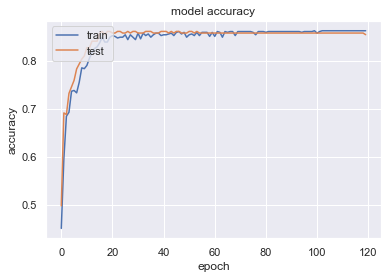

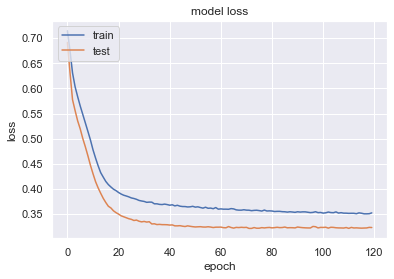

In [143]:
model = Sequential()
model.add(Dense(8, input_dim=9, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X, y, validation_split=0.33, epochs=120, batch_size=10, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [153]:
# neural network submission
scaler = StandardScaler().fit(X)
model = Sequential()
model.add(Dense(8, input_dim=9, activation='relu'))
    #model.add(Dropout(0.2))
model.add(Dense(3, activation='relu'))
    #model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
model.fit(X, y, epochs=120, batch_size=20)

result = model.predict_classes(scaler.transform(X_test)).ravel()

result

Epoch 1/120
45/45 [==============================] - 0s 754us/step - loss: 0.6962 - accuracy: 0.4534
Epoch 2/120
45/45 [==============================] - 0s 798us/step - loss: 0.6673 - accuracy: 0.6745
Epoch 3/120
45/45 [==============================] - 0s 709us/step - loss: 0.6219 - accuracy: 0.7374
Epoch 4/120
45/45 [==============================] - 0s 731us/step - loss: 0.5727 - accuracy: 0.7565
Epoch 5/120
45/45 [==============================] - 0s 687us/step - loss: 0.5390 - accuracy: 0.7733
Epoch 6/120
45/45 [==============================] - 0s 665us/step - loss: 0.5106 - accuracy: 0.7789
Epoch 7/120
45/45 [==============================] - 0s 776us/step - loss: 0.4818 - accuracy: 0.7845
Epoch 8/120
45/45 [==============================] - 0s 709us/step - loss: 0.4515 - accuracy: 0.7856
Epoch 9/120
45/45 [==============================] - 0s 731us/step - loss: 0.4244 - accuracy: 0.8092
Epoch 10/120
45/45 [==============================] - 0s 864us/step - loss: 0.4054 - accura

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [157]:
for i in range(len(result)):
    test_.iloc[i]['Survived']=result[i]
    
test_['Survived'] = test_['Survived'].astype(int)
submit = test_[['PassengerId','Survived']]
submit.to_csv("submit_nn.csv", index=False)

### Try to use Recursive feature elimination which is to select features by recursively considering smaller and smaller sets of features

In [145]:
dtree_rfe = feature_selection.RFECV(model_dt, step = 1, scoring = 'accuracy', cv = 10)
dtree_rfe.fit(X, y)


X_rfe = X.columns.values[dtree_rfe.get_support()]
rfe_results = cross_validate(model_dt, X, y, cv  = 10,return_train_score=True)

print('AFTER DT RFE Training Shape New: ', X[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

AFTER DT RFE Training Shape New:  (891, 3)
AFTER DT RFE Training Columns New:  ['IsMale' 'WcgAllSurvived' 'WcgAllDied']
AFTER DT RFE Training w/bin score mean: 88.91
AFTER DT RFE Test w/bin score mean: 84.40
AFTER DT RFE Test w/bin score 3*std: +/- 9.66
----------


### Putting all finetuning into one

In [158]:
import time
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

estimators = [
    ('ada', AdaBoostClassifier()),
    ('bc', BaggingClassifier()),
    ('etc', ExtraTreesClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),    
    ('lr', linear.LogisticRegressionCV()),
    ('knn', KNeighborsClassifier()),
    ('svc', SVC(probability=True)),
    
    ('xgb', xgb.XGBClassifier())]
params = [
            [{
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            'random_state': grid_seed
            }],
       
            [{
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

            [{
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],

            [{
            'loss': ['deviance', 'exponential'], 
            'learning_rate': [.05],
            'n_estimators': [300], 
            'criterion': ['friedman_mse', 'mse', 'mae'], 
            'max_depth': grid_max_depth,    
            'random_state': grid_seed
             }],

            [{
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],
    
            [{
            'fit_intercept': grid_bool, 
            'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
            'random_state': grid_seed
             }],
            

            [{
            'n_neighbors': [1,2,3,4,5,6,7], 
            'weights': ['uniform', 'distance'], 
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], 
            'gamma': grid_ratio,
            'decision_function_shape': ['ovo', 'ovr'], 
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            'learning_rate': grid_learn, 
            'max_depth': [1,2,4,6,8,10], 
            'estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]
    ]   

start_total = time.perf_counter() 
for clf, param in zip(estimators, params): 

    print(clf[1]) 
    
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator = clf[1], param_grid = param, cv = 10, scoring = 'accuracy')
    best_search.fit(X, y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))




AdaBoostClassifier()
The best parameter for AdaBoostClassifier is {'learning_rate': 0.03, 'n_estimators': 300, 'random_state': 0} with a runtime of 39.66 seconds.
BaggingClassifier()
The best parameter for BaggingClassifier is {'max_samples': 0.5, 'n_estimators': 50, 'random_state': 0} with a runtime of 43.15 seconds.
ExtraTreesClassifier()
The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100, 'random_state': 0} with a runtime of 63.64 seconds.
GradientBoostingClassifier()
The best parameter for GradientBoostingClassifier is {'criterion': 'mae', 'learning_rate': 0.05, 'loss': 'exponential', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 564.44 seconds.
RandomForestClassifier()
The best parameter for RandomForestClassifier is {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 84.09 seconds.
LogisticRegressionCV()
The best parameter for LogisticRegressionCV is {'fit

### Voting mechasims

In [147]:

estimators = [
    ('ada', AdaBoostClassifier()),
    ('bc', BaggingClassifier()),
    ('etc', ExtraTreesClassifier()),
    ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),    
    ('lr', linear.LogisticRegressionCV()),

    ('knn', KNeighborsClassifier()),
    ('svc', SVC(probability=True)),
    ('xgb', xgb.XGBClassifier())]

vote_soft = VotingClassifier(estimators = estimators, voting = 'soft')
vote_soft_cv = cross_validate(vote_soft, X,y, cv  = 10,return_train_score=True)
vote_soft.fit(X,y)

vote_hard = VotingClassifier(estimators = estimators, voting = 'hard')
vote_hard_cv = cross_validate(vote_hard, X,y, cv  = 10,return_train_score=True)
vote_hard.fit(X, y)
print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

Hard Voting Training w/bin score mean: 88.19
Hard Voting Test w/bin score mean: 84.85
Hard Voting Test w/bin score 3*std: +/- 9.61
----------
Soft Voting Training w/bin score mean: 88.33
Soft Voting Test w/bin score mean: 84.40
Soft Voting Test w/bin score 3*std: +/- 9.64
----------


In [148]:
test_['Survived'] = vote_hard.predict(X_test)
test_['Survived'] = test_['Survived'].astype(int)
submit = test_[['PassengerId','Survived']]
submit.to_csv("submit_voting.csv", index=False)

LR: 0.856330 (0.039857)
BG: 0.849625 (0.026563)
KNN: 0.822747 (0.039665)
Random F: 0.822747 (0.039665)
CART: 0.851885 (0.029004)
XGB: 0.846317 (0.037828)
SVM: 0.859688 (0.040023)


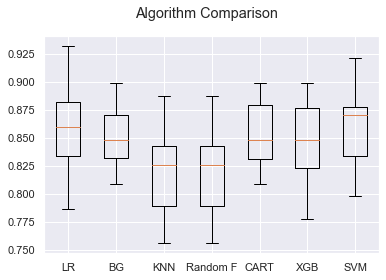

In [152]:
from sklearn import model_selection

models = []
models.append(('LR', LogisticRegression()))
models.append(('BG', BaggingClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random F', KNeighborsClassifier()))
models.append(('CART', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))
models.append(('SVM', SVC()))

results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()